<a href="https://www.kaggle.com/code/burcakaydn/house-price-prediction?scriptVersionId=170352896" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

#### Dataset Description:
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [2]:
# Task 1: Exploratory Data Analysis
# Step 1: Read and combine the Train and Test data sets. Proceed through the data you combined. 
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
df = pd.concat([train, test]).reset_index(drop=True)
print(df.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [3]:
# Step 2: Capture numerical and categorical variables.
def check_df(dataframe):
    # Print the shape of the DataFrame
    print("##################### Shape #####################")
    print(dataframe.shape)
    
    # Print the data types of columns
    print("##################### Types #####################")
    print(dataframe.dtypes)
    
    # Print the first three rows
    print("##################### Head #####################")
    print(dataframe.head(3))
    
    # Print the last three rows
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    
    # Print the count of missing values for each column
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    
    # Select numerical columns
    num_df = dataframe.select_dtypes(include=['float64', 'int64'])
    
    # Calculate and print quantiles for numerical columns
    print("##################### Quantiles #####################")
    print(num_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(2919, 81)
##################### Types #####################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 81, dtype: object
##################### Head #####################
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 2919
Variables: 81
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


In [5]:
def cat_summary(df, col_name, plot=False):
    """
    Summarizes a categorical column in a DataFrame by displaying the counts and ratios of its unique values.
    Optionally, plots a count plot of the categorical distribution.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        col_name (str): The name of the categorical column to summarize.
        plot (bool): If True, a count plot of the column is displayed.

    Returns:
        None: Prints the counts and ratios of the column's unique values and displays a plot if requested.
    """
    # Creates a new dataframe with the counts of occurrences for each unique value in the specified column
    # Also calculates the ratio of each unique value as a percentage of the total number of observations
    print(pd.DataFrame({col_name: df[col_name].value_counts(),
                        "Ratio": 100 * df[col_name].value_counts() / len(df)}))
    
    # If the plot parameter is set to True, generates a count plot for the specified column
    if plot:
        sns.countplot(x=col_name, data=df)
        plt.show()
        


In [6]:
def cat_summary(df, col_name, plot=False):
    """
    Summarizes a categorical column in a DataFrame by displaying the counts and ratios of its unique values.
    Optionally, plots a count plot of the categorical distribution.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        col_name (str): The name of the categorical column to summarize.
        plot (bool): If True, a count plot of the column is displayed.

    Returns:
        None: Prints the counts and ratios of the column's unique values and displays a plot if requested.
    """
    # Creates a new dataframe with the counts of occurrences for each unique value in the specified column
    # Also calculates the ratio of each unique value as a percentage of the total number of observations
    print(pd.DataFrame({col_name: df[col_name].value_counts(),
                        "Ratio": 100 * df[col_name].value_counts() / len(df)}))
    
    # If the plot parameter is set to True, generates a count plot for the specified column
    if plot:
        sns.countplot(x=col_name, data=df)
        plt.show()

count    2919.000000
mean     1460.000000
std       842.787043
min         1.000000
5%        146.900000
10%       292.800000
20%       584.600000
30%       876.400000
40%      1168.200000
50%      1460.000000
60%      1751.800000
70%      2043.600000
80%      2335.400000
90%      2627.200000
95%      2773.100000
99%      2889.820000
max      2919.000000
Name: Id, dtype: float64


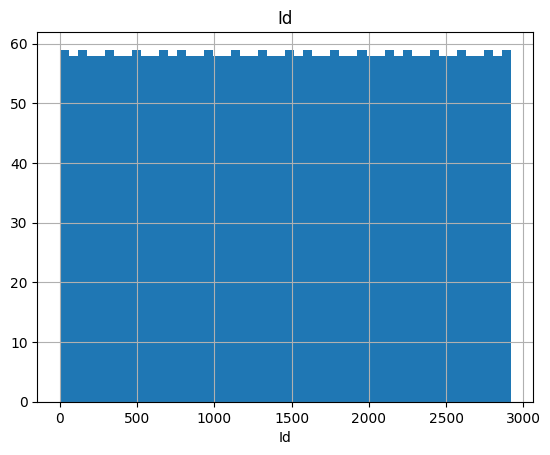

#####################################
count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
5%         20.000000
10%        20.000000
20%        20.000000
30%        20.000000
40%        30.000000
50%        50.000000
60%        60.000000
70%        60.000000
80%        80.000000
90%       120.000000
95%       160.000000
99%       190.000000
max       190.000000
Name: MSSubClass, dtype: float64


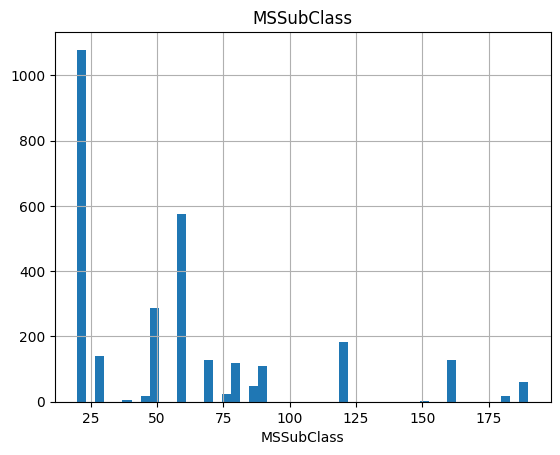

#####################################
count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
5%         32.000000
10%        43.000000
20%        53.000000
30%        60.000000
40%        63.000000
50%        68.000000
60%        73.000000
70%        78.000000
80%        84.000000
90%        95.000000
95%       107.000000
99%       135.680000
max       313.000000
Name: LotFrontage, dtype: float64


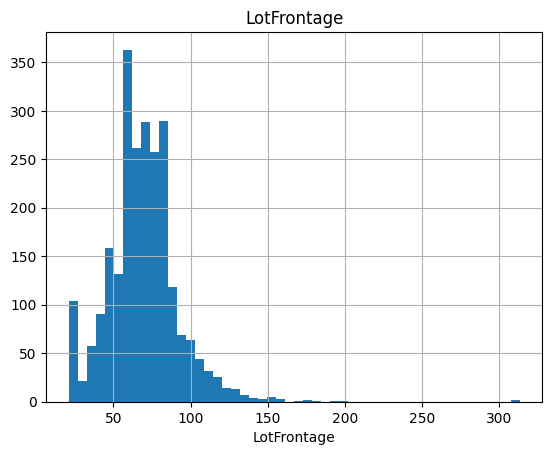

#####################################
count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
5%         3182.000000
10%        4922.400000
20%        7007.600000
30%        7960.400000
40%        8741.000000
50%        9453.000000
60%       10151.600000
70%       11001.200000
80%       12203.800000
90%       14300.600000
95%       17142.900000
99%       33038.640000
max      215245.000000
Name: LotArea, dtype: float64


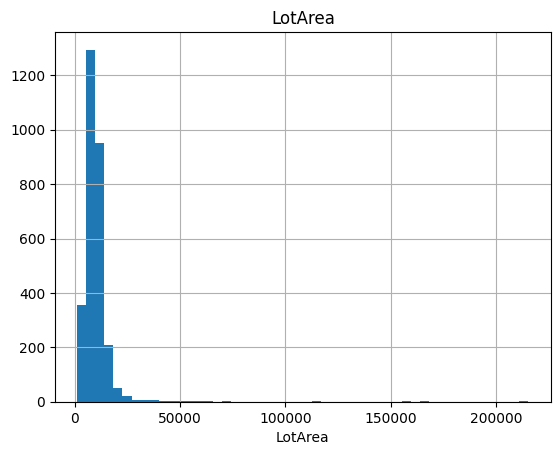

#####################################
count    2919.000000
mean        6.089072
std         1.409947
min         1.000000
5%          4.000000
10%         5.000000
20%         5.000000
30%         5.000000
40%         6.000000
50%         6.000000
60%         6.000000
70%         7.000000
80%         7.000000
90%         8.000000
95%         8.000000
99%        10.000000
max        10.000000
Name: OverallQual, dtype: float64


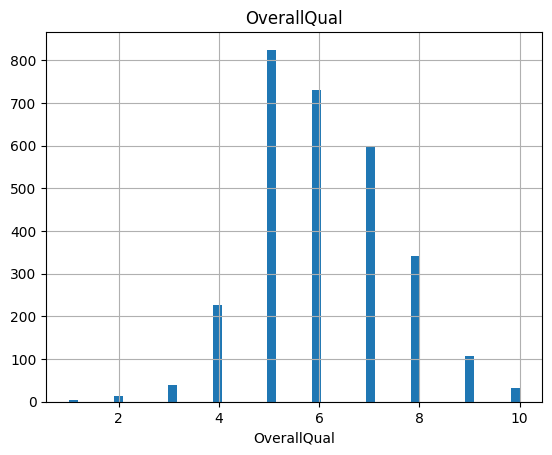

#####################################
count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
5%       1915.000000
10%      1924.000000
20%      1947.000000
30%      1957.000000
40%      1965.000000
50%      1973.000000
60%      1984.000000
70%      1998.000000
80%      2003.000000
90%      2006.000000
95%      2007.000000
99%      2008.000000
max      2010.000000
Name: YearBuilt, dtype: float64


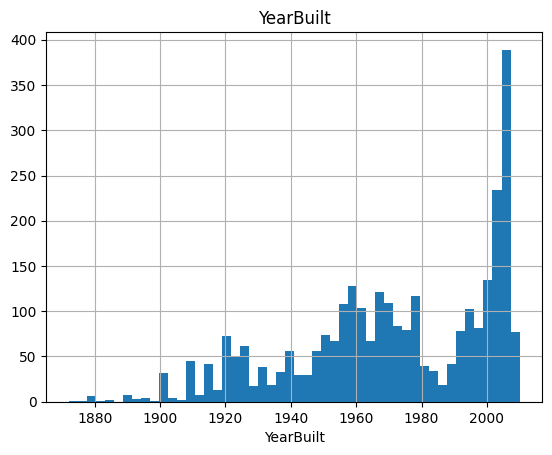

#####################################
count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
5%       1950.000000
10%      1950.000000
20%      1960.000000
30%      1970.000000
40%      1978.000000
50%      1993.000000
60%      1998.000000
70%      2002.000000
80%      2005.000000
90%      2006.200000
95%      2007.000000
99%      2009.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


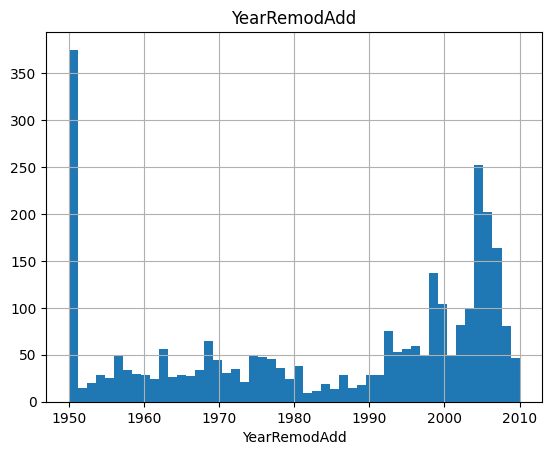

#####################################
count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%       120.000000
80%       202.000000
90%       325.500000
95%       466.500000
99%       771.050000
max      1600.000000
Name: MasVnrArea, dtype: float64


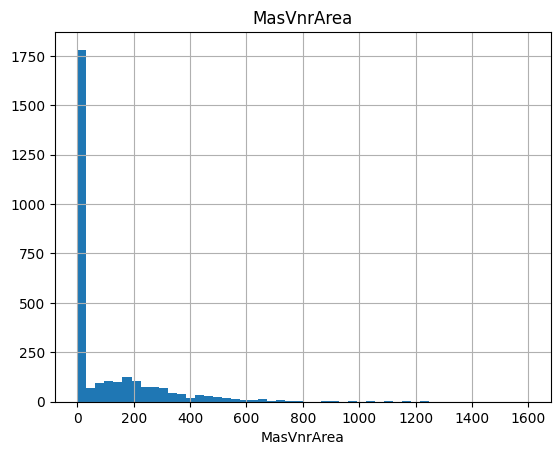

#####################################
count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%       202.600000
50%       368.500000
60%       515.200000
70%       656.000000
80%       812.000000
90%      1056.900000
95%      1274.000000
99%      1635.320000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


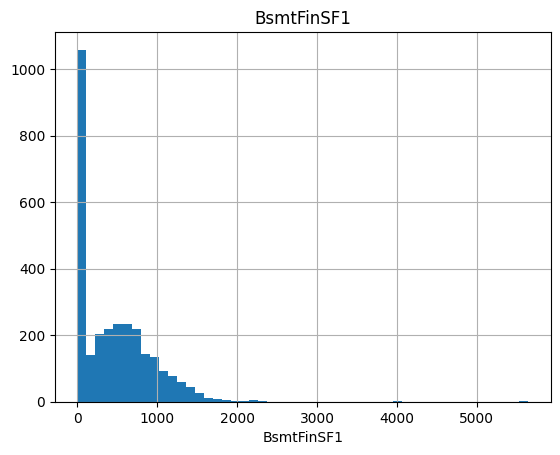

#####################################
count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       125.600000
95%       435.000000
99%       874.660000
max      1526.000000
Name: BsmtFinSF2, dtype: float64


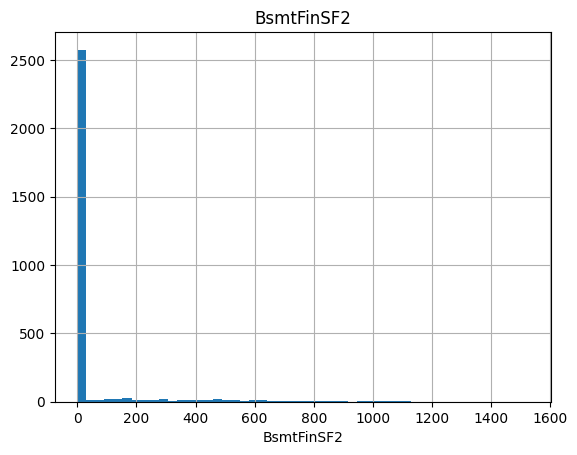

#####################################
count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
5%          0.000000
10%        56.000000
20%       174.000000
30%       270.000000
40%       365.800000
50%       467.000000
60%       595.000000
70%       732.000000
80%       892.600000
90%      1212.600000
95%      1474.900000
99%      1776.490000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


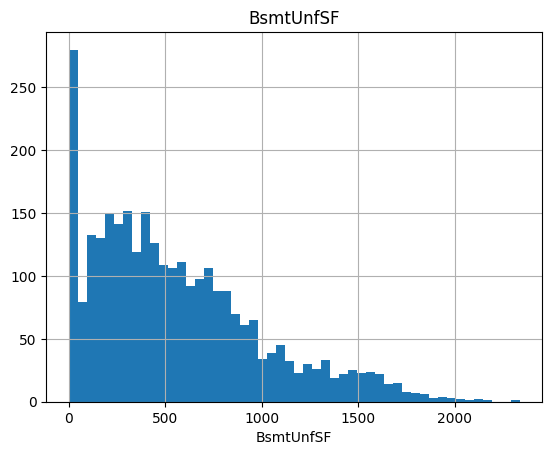

#####################################
count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
5%        455.250000
10%       600.000000
20%       741.000000
30%       836.000000
40%       911.000000
50%       989.500000
60%      1089.200000
70%      1216.000000
80%      1392.000000
90%      1614.000000
95%      1776.150000
99%      2198.300000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


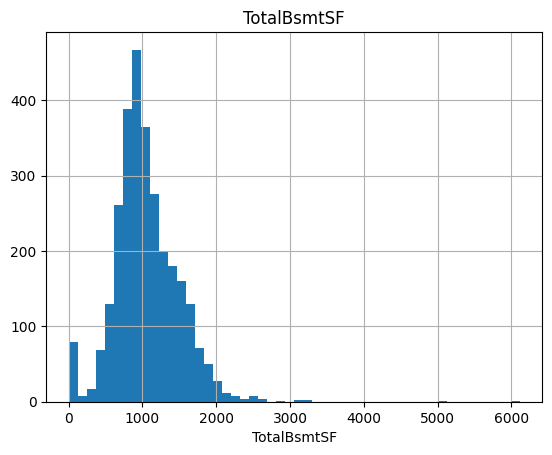

#####################################
count    2919.000000
mean     1159.581706
std       392.362079
min       334.000000
5%        665.900000
10%       744.800000
20%       847.000000
30%       914.000000
40%       996.200000
50%      1082.000000
60%      1180.000000
70%      1314.000000
80%      1483.400000
90%      1675.000000
95%      1830.100000
99%      2288.020000
max      5095.000000
Name: 1stFlrSF, dtype: float64


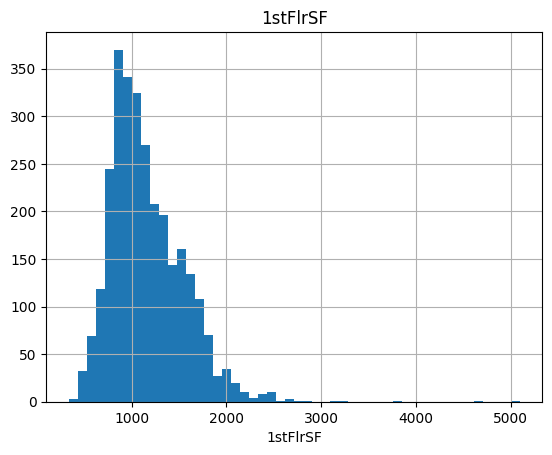

#####################################
count    2919.000000
mean      336.483727
std       428.701456
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       427.400000
70%       636.000000
80%       770.800000
90%       925.000000
95%      1131.200000
99%      1400.200000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


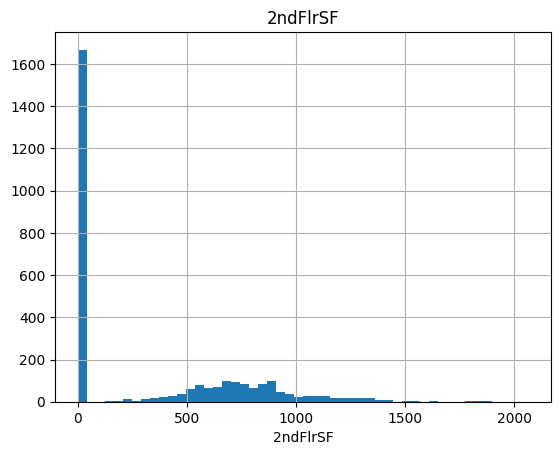

#####################################
count    2919.000000
mean        4.694416
std        46.396825
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       153.840000
max      1064.000000
Name: LowQualFinSF, dtype: float64


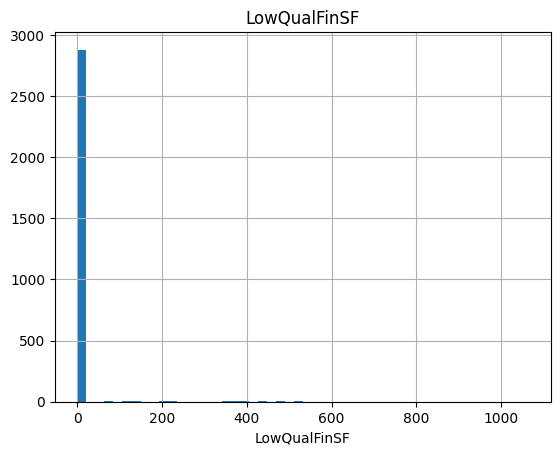

#####################################
count    2919.000000
mean     1500.759849
std       506.051045
min       334.000000
5%        861.000000
10%       923.800000
20%      1064.600000
30%      1200.000000
40%      1329.200000
50%      1444.000000
60%      1560.000000
70%      1680.000000
80%      1838.400000
90%      2153.200000
95%      2464.200000
99%      2935.720000
max      5642.000000
Name: GrLivArea, dtype: float64


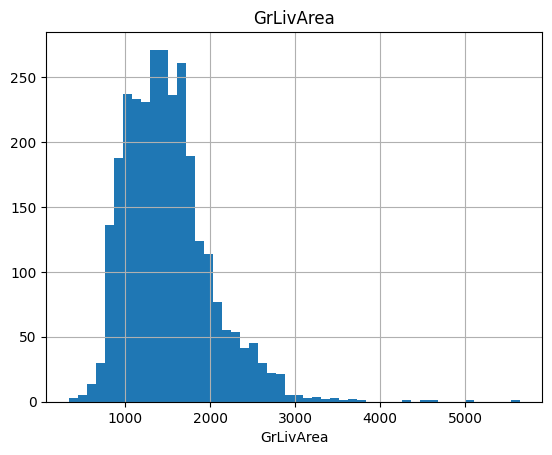

#####################################
count    2919.000000
mean        6.451524
std         1.569379
min         2.000000
5%          4.000000
10%         5.000000
20%         5.000000
30%         6.000000
40%         6.000000
50%         6.000000
60%         7.000000
70%         7.000000
80%         8.000000
90%         8.000000
95%         9.000000
99%        11.000000
max        15.000000
Name: TotRmsAbvGrd, dtype: float64


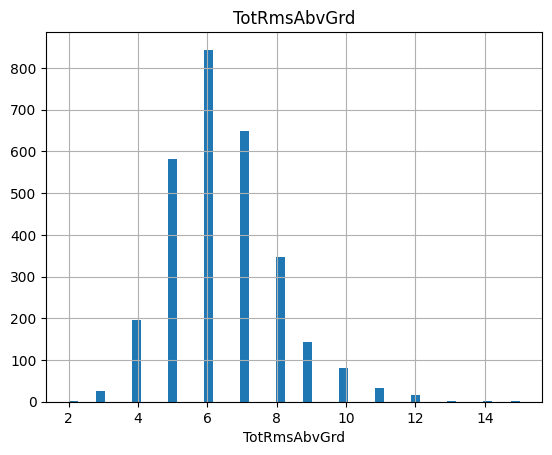

#####################################
count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
5%       1928.000000
10%      1941.000000
20%      1957.000000
30%      1964.000000
40%      1972.000000
50%      1979.000000
60%      1993.000000
70%      1999.000000
80%      2004.000000
90%      2006.000000
95%      2007.000000
99%      2009.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


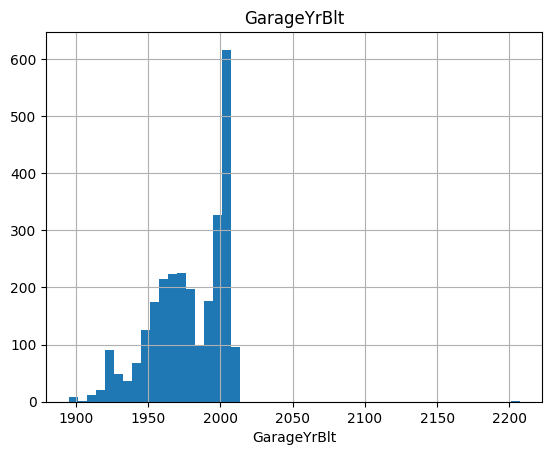

#####################################
count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
5%          0.000000
10%       240.000000
20%       296.000000
30%       379.000000
40%       440.000000
50%       480.000000
60%       513.000000
70%       560.900000
80%       621.000000
90%       758.000000
95%       856.150000
99%      1019.490000
max      1488.000000
Name: GarageArea, dtype: float64


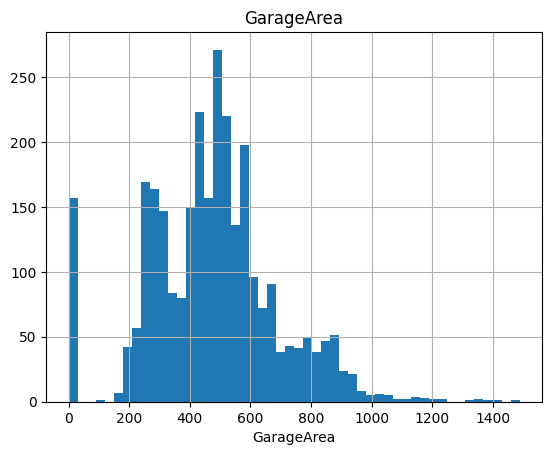

#####################################
count    2919.000000
mean       93.709832
std       126.526589
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       100.000000
70%       144.000000
80%       192.000000
90%       257.000000
95%       328.000000
99%       500.820000
max      1424.000000
Name: WoodDeckSF, dtype: float64


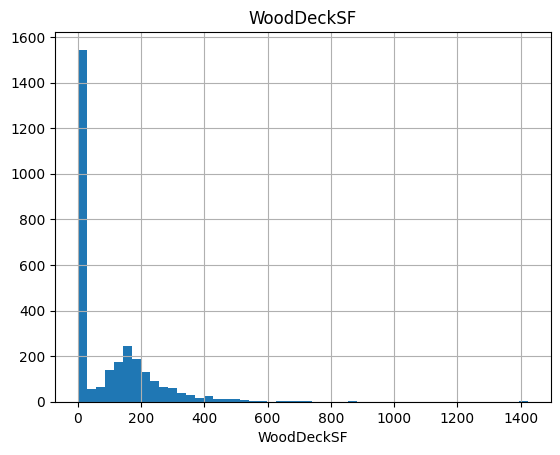

#####################################
count    2919.000000
mean       47.486811
std        67.575493
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%        26.000000
60%        40.000000
70%        58.000000
80%        85.000000
90%       131.200000
95%       183.100000
99%       284.460000
max       742.000000
Name: OpenPorchSF, dtype: float64


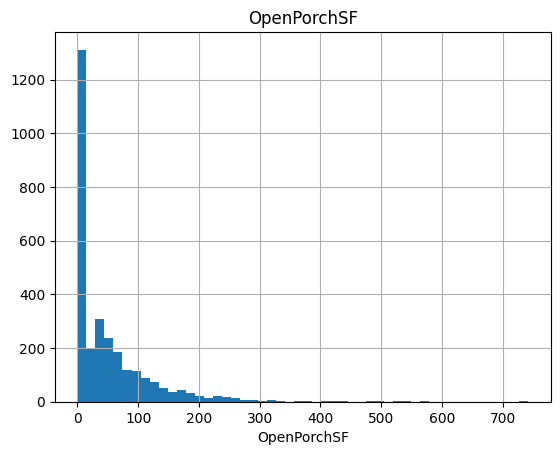

#####################################
count    2919.000000
mean       23.098321
std        64.244246
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       112.000000
95%       176.000000
99%       264.000000
max      1012.000000
Name: EnclosedPorch, dtype: float64


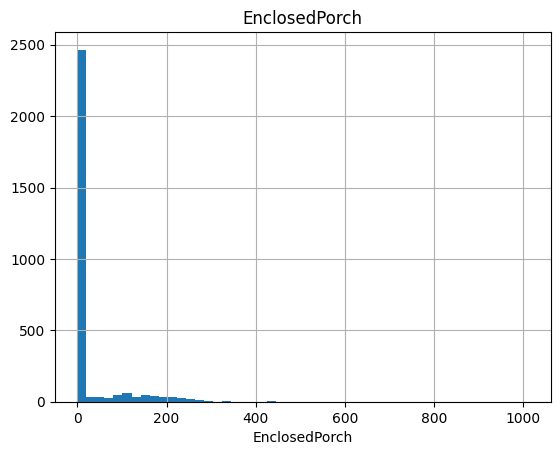

#####################################
count    2919.000000
mean        2.602261
std        25.188169
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       144.000000
max       508.000000
Name: 3SsnPorch, dtype: float64


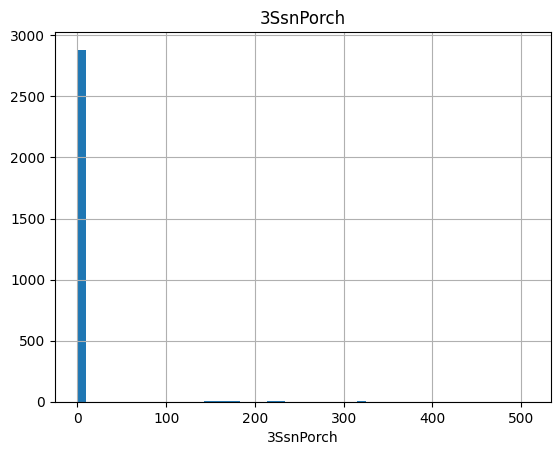

#####################################
count    2919.000000
mean       16.062350
std        56.184365
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%       161.000000
99%       259.820000
max       576.000000
Name: ScreenPorch, dtype: float64


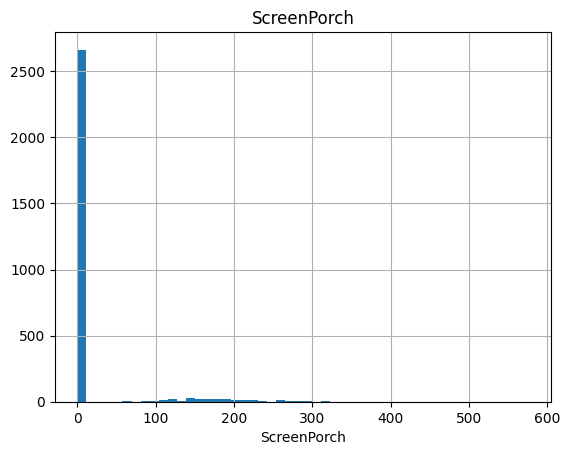

#####################################
count    2919.000000
mean        2.251799
std        35.663946
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%         0.000000
max       800.000000
Name: PoolArea, dtype: float64


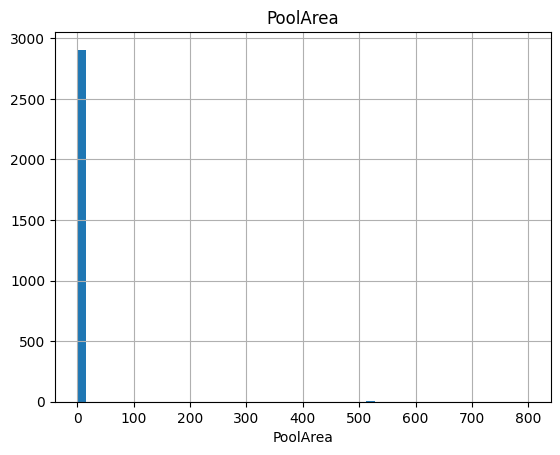

#####################################
count     2919.000000
mean        50.825968
std        567.402211
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          0.000000
90%          0.000000
95%          0.000000
99%        982.000000
max      17000.000000
Name: MiscVal, dtype: float64


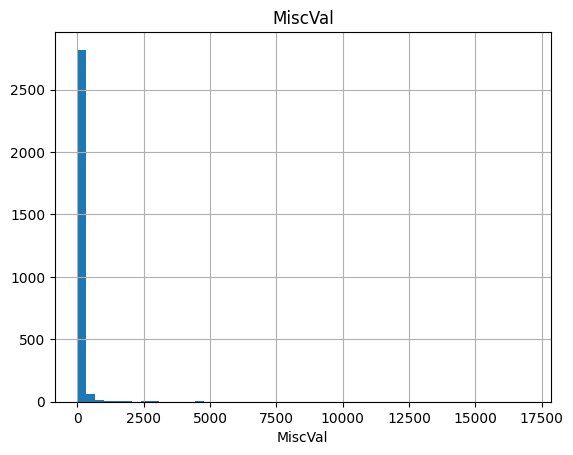

#####################################
count    2919.000000
mean        6.213087
std         2.714762
min         1.000000
5%          2.000000
10%         3.000000
20%         4.000000
30%         5.000000
40%         6.000000
50%         6.000000
60%         7.000000
70%         7.000000
80%         8.000000
90%        10.000000
95%        11.000000
99%        12.000000
max        12.000000
Name: MoSold, dtype: float64


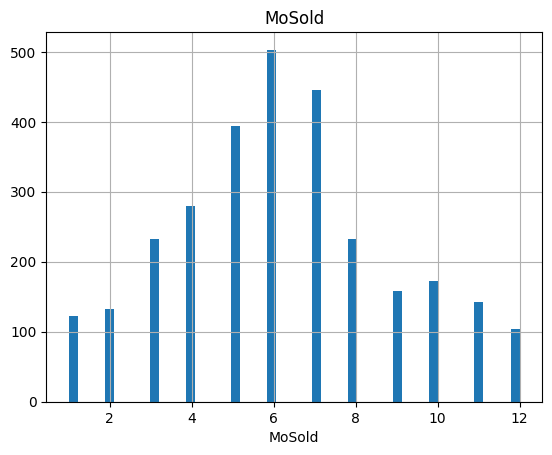

#####################################
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
5%        88000.000000
10%      106475.000000
20%      124000.000000
30%      135500.000000
40%      147000.000000
50%      163000.000000
60%      179280.000000
70%      198620.000000
80%      230000.000000
90%      278000.000000
95%      326100.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64


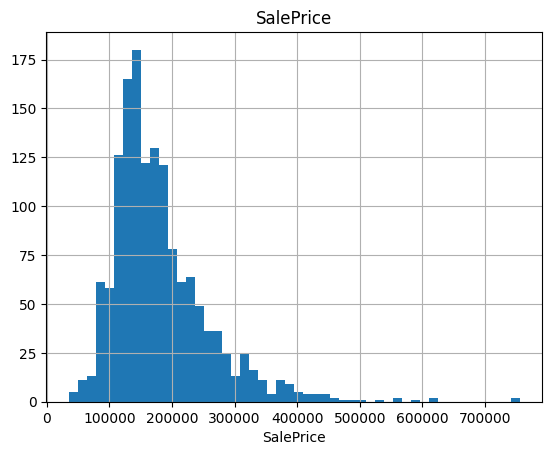

#####################################


In [7]:
# Step 3: Make the necessary arrangements. (such as variables with type errors)
# Step 4: Observe the distribution of numerical and categorical variables in the data.
# Define a function to summarize numerical columns in a DataFrame
def num_summary(dataframe, numerical_col, plot=False):
    """
    Provides summary statistics and optionally plots a histogram for numerical columns in a DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        numerical_col (str): The name of the numerical column to summarize.
        plot (bool): If True, a histogram of the column is displayed.

    Returns:
        None: Prints the summary statistics and displays a plot if requested.
    """
    # Define the quantiles to include in the summary
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    # Print the descriptive statistics including the specified quantiles
    print(dataframe[numerical_col].describe(quantiles).T)

    # If plot is True, plot a histogram of the numerical column
    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    # Print a separator for readability when summarizing multiple columns
    print("#####################################")

# Assuming 'df' is your DataFrame and 'num_cols' is a list of numerical columns in 'df'
# num_cols = ['col1', 'col2', ...]  # Define your numerical columns here

# Loop through each numerical column and apply the summary function
for col in num_cols:
    num_summary(df, col, True)


In [8]:
# Step 5: Examine the target variable with categorical variables. 
def target_summary_with_cat(dataframe, target, categorical_col):
    """
    Analyzes the relationship between a categorical variable and a target variable by computing
    the mean of the target variable for each category in the categorical variable.
    
    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        target (str): The name of the target variable.
        categorical_col (str): The name of the categorical variable.
        
    Returns:
        None: Prints the mean of the target variable for each category in the categorical variable.
    """
    # Group the dataframe by the categorical column and calculate the mean of the target variable for 
    # each category
    target_mean_by_category = dataframe.groupby(categorical_col)[target].mean()
    
    # Create a DataFrame from the target mean by category for better display
    target_mean_df = pd.DataFrame({"TARGET_MEAN": target_mean_by_category})
    
    # Print the resulting DataFrame
    print(target_mean_df, end="\n\n\n")

# Assuming 'cat_cols' is a list of categorical columns in 'df'
# cat_cols = ['category_col1', 'category_col2', ...]  # Define your categorical columns here
# And assuming 'df' is your DataFrame and 'SalePrice' is the target variable

# Loop through each categorical column and apply the target summary function
for col in cat_cols:
    target_summary_with_cat(df, "SalePrice", col)


            TARGET_MEAN
MSZoning               
C (all)    74528.000000
FV        214014.061538
RH        131558.375000
RL        191004.994787
RM        126316.830275


          TARGET_MEAN
Street               
Grvl    130190.500000
Pave    181130.538514


         TARGET_MEAN
Alley               
Grvl   122219.080000
Pave   168000.585366


            TARGET_MEAN
LotShape               
IR1       206101.665289
IR2       239833.365854
IR3       216036.500000
Reg       164754.818378


               TARGET_MEAN
LandContour               
Bnk          143104.079365
HLS          231533.940000
Low          203661.111111
Lvl          180183.746758


            TARGET_MEAN
Utilities              
AllPub     180950.95682
NoSeWa     137500.00000


             TARGET_MEAN
LotConfig               
Corner     181623.425856
CulDSac    223854.617021
FR2        177934.574468
FR3        208475.000000
Inside     176938.047529


             TARGET_MEAN
LandSlope               
Gtl        179956.7

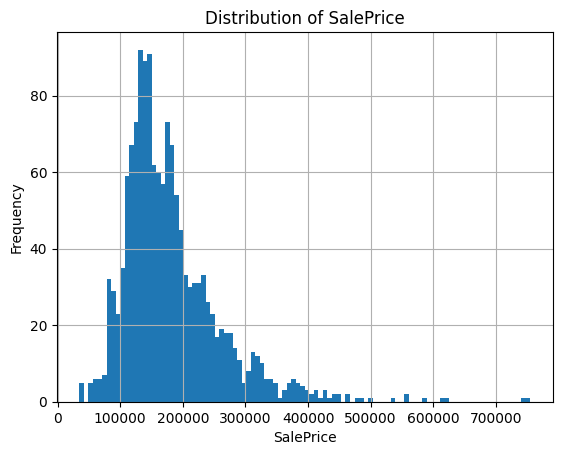

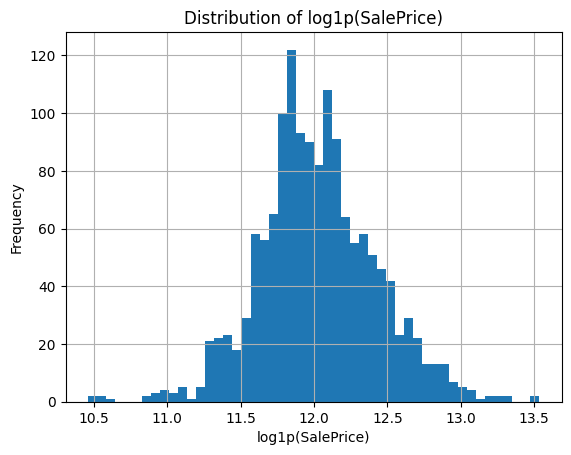

In [9]:
import numpy as np
# Step 6: Examine if there are any contradictory observations.
# Step 7: Check if there are any missing observations.
# Plot the histogram of the SalePrice column with 100 bins for finer detail
df["SalePrice"].hist(bins=100)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Applying a log transformation (log1p) to the SalePrice to examine its distribution
# This transformation is often used to make highly skewed distributions less skewed, 
# which can be helpful for linear regression models among others.
np.log1p(df['SalePrice']).hist(bins=50)
plt.title('Distribution of log1p(SalePrice)')
plt.xlabel('log1p(SalePrice)')
plt.ylabel('Frequency')
plt.show()

                     Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id             1.000000    0.008931    -0.027549 -0.040746    -0.029771   
MSSubClass     0.008931    1.000000    -0.417359 -0.201730     0.033638   
LotFrontage   -0.027549   -0.417359     1.000000  0.489896     0.217645   
LotArea       -0.040746   -0.201730     0.489896  1.000000     0.100541   
OverallQual   -0.029771    0.033638     0.217645  0.100541     1.000000   
YearBuilt     -0.016581    0.034409     0.122811  0.024128     0.597554   
YearRemodAdd  -0.050438    0.043315     0.091557  0.021612     0.571532   
MasVnrArea    -0.025219    0.005433     0.221079  0.125596     0.432947   
BsmtFinSF1    -0.016947   -0.064311     0.219408  0.194031     0.281810   
BsmtFinSF2     0.018251   -0.072530     0.047431  0.084059    -0.042771   
BsmtUnfSF     -0.014453   -0.125994     0.113714  0.021362     0.275175   
TotalBsmtSF   -0.024924   -0.219965     0.354822  0.254138     0.549294   
1stFlrSF      -0.008678  

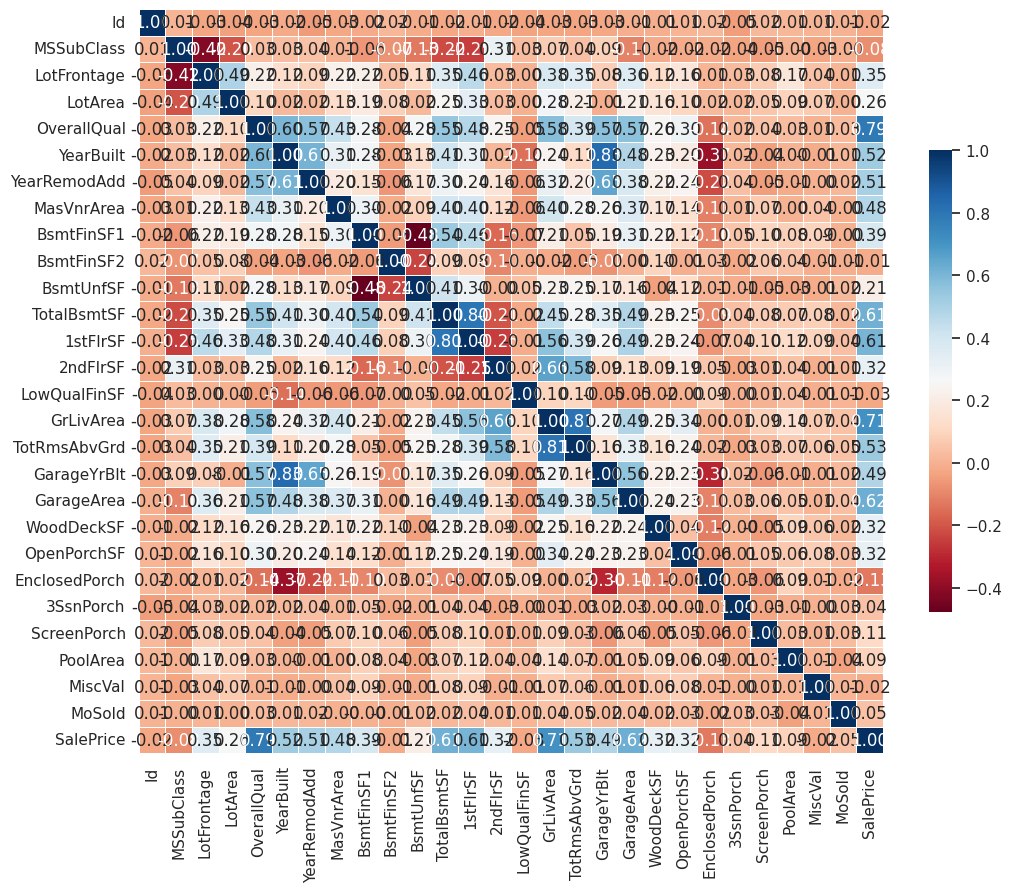

In [10]:
# Calculate the correlation matrix for numerical columns in the DataFrame
corr = df[num_cols].corr()

# Display the correlation matrix
print(corr)

# Set the size of the figure to make the heatmap larger and easier to read
sns.set(rc={'figure.figsize': (12, 12)})

# Create a heatmap to visualize the correlations
# cmap="RdBu" is used to set the color map to a diverging color scheme, which is useful for highlighting both
# positive (blue) and negative (red) correlations. Adjustments can be made for better visual distinction.
sns.heatmap(corr, cmap="RdBu", annot=True, square=True, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .5})

# Display the heatmap
plt.show()

In [11]:
# Task 2: Feature Engineering
# Step 1: Take the necessary action for missing and contradictory observations.
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    """Calculate low and high thresholds for outlier detection."""
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [12]:
def check_outlier(dataframe, col_name):
    """Check if a column in a dataframe has any outliers."""
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    return False

# Example loop to check outliers for numerical columns
for col in num_cols:
    if col != "SalePrice":
        print(f"{col} has outliers: {check_outlier(df, col)}")

Id has outliers: False
MSSubClass has outliers: False
LotFrontage has outliers: True
LotArea has outliers: True
OverallQual has outliers: False
YearBuilt has outliers: False
YearRemodAdd has outliers: False
MasVnrArea has outliers: True
BsmtFinSF1 has outliers: True
BsmtFinSF2 has outliers: True
BsmtUnfSF has outliers: False
TotalBsmtSF has outliers: True
1stFlrSF has outliers: True
2ndFlrSF has outliers: False
LowQualFinSF has outliers: True
GrLivArea has outliers: True
TotRmsAbvGrd has outliers: True
GarageYrBlt has outliers: True
GarageArea has outliers: False
WoodDeckSF has outliers: True
OpenPorchSF has outliers: True
EnclosedPorch has outliers: True
3SsnPorch has outliers: True
ScreenPorch has outliers: True
PoolArea has outliers: True
MiscVal has outliers: True
MoSold has outliers: False


In [13]:
def replace_with_thresholds(dataframe, variable):
    """Replace outliers in a dataframe column with threshold values."""
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Example loop to replace outliers for numerical columns
for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df, col)

/tmp/ipykernel_18/3132816722.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3208.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
/tmp/ipykernel_18/3132816722.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-9144.900000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
/tmp/ipykernel_18/3132816722.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_

In [14]:
def missing_values_table(dataframe, na_name=False):
    """
    Displays the number of missing values and the percentage of the total missing values in each column.
    
    Args:
        dataframe (pd.DataFrame): The DataFrame to analyze.
        na_name (bool): If True, returns the names of columns with missing values.

    Returns:
        List of columns with missing values if na_name is True. Otherwise, None.
    """
    # Identify columns that have missing values
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    
    # Count the number of missing values per column
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    
    # Calculate the percentage of missing values per column
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    
    # Combine the counts and percentages into a single DataFrame for display
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    
    # Print the missing values table
    print(missing_df, end="\n\n")
    
    # Optionally return the names of columns with missing values
    if na_name:
        return na_columns
    
missing_values_table(df)

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
MasVnrType      1766  60.50
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [15]:
def missing_values_table(dataframe):
    """
    Function to print the number of missing values and the percentage
    of the total missing values in each column that has missing values.
    """
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n\n")

In [16]:
# Specified columns where missing values indicate the absence of a feature
no_cols = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
           "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish",
           "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

# Replacing missing values with 'No' to indicate absence of the feature
for col in no_cols:
    df[col].fillna("No", inplace=True)

# Checking the dataframe for any other missing values
missing_values_table(df)

              n_miss  ratio
MasVnrType      1766  60.50
SalePrice       1459  49.98
LotFrontage      486  16.65
GarageYrBlt      159   5.45
MasVnrArea        23   0.79
MSZoning           4   0.14
BsmtFullBath       2   0.07
BsmtHalfBath       2   0.07
Functional         2   0.07
Utilities          2   0.07
Exterior2nd        1   0.03
BsmtFinSF1         1   0.03
BsmtFinSF2         1   0.03
BsmtUnfSF          1   0.03
Exterior1st        1   0.03
Electrical         1   0.03
KitchenQual        1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
SaleType           1   0.03
TotalBsmtSF        1   0.03



/tmp/ipykernel_18/548987360.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("No", inplace=True)


In [17]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    """
    Imputes missing values in a DataFrame using mode for categorical variables
    and mean or median for numerical variables based on the num_method parameter.

    Args:
        data (pd.DataFrame): DataFrame to process.
        num_method (str): The method for imputing numerical variables ('mean' or 'median').
        cat_length (int): The maximum number of unique values for treating a variable as categorical.
        target (str): The target variable name to be excluded from imputation.

    Returns:
        pd.DataFrame: The DataFrame with missing values imputed.
    """
    # List variables with missing values
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]
    
    # Temporarily save target variable to ensure it is not modified
    temp_target = data[target]

    # Display count of missing values before imputation
    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    # Impute categorical variables with mode if they have less or equal unique values than cat_length
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # Impute numerical variables based on num_method
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    # Restore target variable
    data[target] = temp_target

    # Display count of missing values after imputation
    print("# AFTER \nImputation method is 'MODE' for categorical variables!")
    print(f"Imputation method is '{num_method.upper()}' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data

# Example usage
df = quick_missing_imp(df, num_method="median", cat_length=17)


# BEFORE
MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64 


# AFTER 
Imputation method is 'MODE' for categorical variables!
Imputation method is 'MEDIAN' for numeric variables! 

MSZoning           0
LotFrontage        0
Utilities          0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Electrical         0
BsmtFullBath       0
BsmtHalfBath       0
KitchenQual        0
Functional         0
GarageYrBlt        0
GarageCars         0
GarageArea         0
SaleType        

In [18]:
def rare_analyser(dataframe, target, cat_cols):
    """
    Analyzes the distribution of categorical columns in a DataFrame,
    focusing on the frequency and target mean of each category.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        target (str): The name of the target variable.
        cat_cols (list): List of categorical column names to analyze.

    Returns:
        None: Prints the distribution and target mean for categories in each specified column.
    """
    for col in cat_cols:
        # Print the number of unique categories in the column
        print(f"{col} : {len(dataframe[col].value_counts())}")
        # Create a DataFrame showing the count, ratio, and target mean for each category
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


# Example usage:
rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
          COUNT     RATIO    TARGET_MEAN
MSZoning                                
C (all)      25  0.008565   74528.000000
FV          139  0.047619  214014.061538
RH           26  0.008907  131558.375000
RL         2269  0.777321  191004.994787
RM          460  0.157588  126316.830275


Street : 2
        COUNT     RATIO    TARGET_MEAN
Street                                
Grvl       12  0.004111  130190.500000
Pave     2907  0.995889  181130.538514


Alley : 3
       COUNT     RATIO    TARGET_MEAN
Alley                                
Grvl     120  0.041110  122219.080000
No      2721  0.932169  183452.131483
Pave      78  0.026721  168000.585366


LotShape : 4
          COUNT     RATIO    TARGET_MEAN
LotShape                                
IR1         968  0.331620  206101.665289
IR2          76  0.026036  239833.365854
IR3          16  0.005481  216036.500000
Reg        1859  0.636862  164754.818378


LandContour : 4
             COUNT     RATIO    TARGET_MEAN
LandCo

In [19]:
def rare_encoder(dataframe, rare_perc):
    """
    Modifies a DataFrame by grouping rare categories in categorical columns into a single 'Rare' category.
    
    Args:
        dataframe (pd.DataFrame): The DataFrame to process.
        rare_perc (float): The threshold percentage for a category to be considered rare. Categories with a proportion
                           less than this threshold within their column will be replaced with 'Rare'.
    
    Returns:
        pd.DataFrame: A copy of the DataFrame with rare categories replaced by 'Rare'.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    temp_df = dataframe.copy()
    
    # Identify categorical columns where any category's proportion is below the specified threshold
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O' 
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
    
    # For each column identified as containing rare categories
    for var in rare_columns:
        # Calculate the proportion of each category
        tmp = temp_df[var].value_counts() / len(temp_df)
        # Identify categories considered rare based on the threshold
        rare_labels = tmp[tmp < rare_perc].index
        # Replace rare categories with 'Rare'
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    
    return temp_df

# Example usage:
# Assuming df is your DataFrame and you want to encode categories that represent less than 1% of the data as 'Rare'
rare_encoder(df, 0.01)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60,RL,65.0,8450.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,2.0,2008,WD,Normal,208500.0
1,2.0,20,RL,80.0,9600.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,5.0,2007,WD,Normal,181500.0
2,3.0,60,RL,68.0,11250.0,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,9.0,2008,WD,Normal,223500.0
3,4.0,70,RL,60.0,9550.0,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,2.0,2006,WD,Abnorml,140000.0
4,5.0,60,RL,84.0,14260.0,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,12.0,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915.0,160,RM,21.0,1936.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,6.0,2006,WD,Normal,NaN
2915,2916.0,160,RM,21.0,1894.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,4.0,2006,WD,Abnorml,NaN
2916,2917.0,20,RL,160.0,20000.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,9.0,2006,WD,Abnorml,NaN
2917,2918.0,85,RL,62.0,10441.0,Pave,No,Reg,Lvl,AllPub,...,0,No,MnPrv,Shed,0,7.0,2006,WD,Normal,NaN


In [20]:
# Example usage:
# Assuming df is your DataFrame and you want to encode categories that represent less than 1% of the data as 'Rare'
df_encoded = rare_encoder(df, 0.01)

# It's a good practice to check the transformation has been applied as expected
print(df_encoded.head())

    Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1.0          60       RL         65.0   8450.0   Pave    No      Reg   
1  2.0          20       RL         80.0   9600.0   Pave    No      Reg   
2  3.0          60       RL         68.0  11250.0   Pave    No      IR1   
3  4.0          70       RL         60.0   9550.0   Pave    No      IR1   
4  5.0          60       RL         84.0  14260.0   Pave    No      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     No    No          No       0    2.0   
1         Lvl    AllPub  ...        0     No    No          No       0    5.0   
2         Lvl    AllPub  ...        0     No    No          No       0    9.0   
3         Lvl    AllPub  ...        0     No    No          No       0    2.0   
4         Lvl    AllPub  ...        0     No    No          No       0   12.0   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008       

In [21]:
# Create a feature representing the product of first floor and total living area.
df["NEW_1st*GrLiv"] = df["1stFlrSF"] * df["GrLivArea"]

# Create a feature for the product of garage area and total living area.
df["NEW_Garage*GrLiv"] = df["GarageArea"] * df["GrLivArea"]

# Calculate the total floor area by adding first and second floor areas.
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"]

# Sum finished areas of the basement for total finished basement area.
df["NEW_TotalBsmtFin"] = df["BsmtFinSF1"] + df["BsmtFinSF2"]

# Aggregate all porch areas into a single porch area feature.
df["NEW_PorchArea"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["ScreenPorch"] + df["3SsnPorch"] + df["WoodDeckSF"]

# Sum total floor area and total basement area for overall house area.
df["NEW_TotalHouseArea"] = df["NEW_TotalFlrSF"] + df["TotalBsmtSF"]

# Combine total living area and total basement area into one feature.
df["NEW_TotalSqFeet"] = df["GrLivArea"] + df["TotalBsmtSF"]

In [22]:
# Living area to lot area ratio.
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea

# Total house area to lot area ratio.
df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea

# Garage area to lot area ratio.
df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea

# Masonry veneer area to total house area ratio.
df["NEW_MasVnrRatio"] = df.MasVnrArea / df.NEW_TotalHouseArea

# Difference in lot area after subtracting first floor, garage, porch, and deck areas.
df["NEW_DifArea"] = (df.LotArea - df["1stFlrSF"] - df.GarageArea - df.NEW_PorchArea - df.WoodDeckSF)

# Product of overall quality and overall condition ratings.
df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"]

# Years between remodeling and original construction.
df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt

# Age of the house at the time of sale.
df["NEW_HouseAge"] = df.YrSold - df.YearBuilt

# Age of the last restoration at the time of sale.
df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd

# Age of the garage since house construction.
df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt

# Absolute years between garage construction and last remodeling.
df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd)

# Years between garage construction and the sale date.
df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt


In [23]:
drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

# Drop specified columns from the DataFrame to simplify the dataset or remove irrelevant features.
df.drop(drop_list, axis=1, inplace=True)


In [24]:
from sklearn.preprocessing import LabelEncoder
# grab_col_names(df) is a predefined function that categorizes columns
cat_cols, cat_but_car, num_cols = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    """
    Applies Label Encoding to binary categorical columns.
    
    Args:
        dataframe (pd.DataFrame): DataFrame to be processed.
        binary_col (str): The name of the binary categorical column.
        
    Returns:
        pd.DataFrame: DataFrame with the binary column encoded.
    """
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

# Identify binary categorical columns for Label Encoding
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]

# Apply Label Encoding to each binary column
for col in binary_cols:
    df = label_encoder(df, col)

Observations: 2919
Variables: 91
cat_cols: 49
num_cols: 42
cat_but_car: 0
num_but_cat: 15


In [25]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    """
    Applies One-Hot Encoding to categorical columns.
    
    Args:
        dataframe (pd.DataFrame): DataFrame to be processed.
        categorical_cols (list): List of categorical columns to be encoded.
        drop_first (bool): Whether to drop the first level of the encoded columns.
        
    Returns:
        pd.DataFrame: DataFrame with categorical columns one-hot encoded.
    """
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

# Apply One-Hot Encoding to categorical columns (excluding binary ones)
non_binary_cat_cols = [col for col in cat_cols if col not in binary_cols]
df = one_hot_encoder(df, non_binary_cat_cols, drop_first=True)


In [26]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np
# Task 3: Modelling
# Step 1: Separate Train and Test data. (Values with empty SalePrice variable are test data.)
# Splitting the DataFrame into training and testing sets based on 'SalePrice' availability
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

# Defining features (X) and target (y)
y = train_df['SalePrice']
X = train_df.drop(["Id", "SalePrice"], axis=1)

# Splitting the training data into train and test sets for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

# List of models to evaluate
models = [
    ('LR', LinearRegression()),
    # Uncomment any models you wish to include in your evaluation
    #("Ridge", Ridge()),
    #("Lasso", Lasso()),
    #("ElasticNet", ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('RF', RandomForestRegressor()),
    #('SVR', SVR()),
    ('GBM', GradientBoostingRegressor()),
    ("XGBoost", XGBRegressor(objective='reg:squarederror')),
    ("LightGBM", LGBMRegressor()),
    ("CatBoost", CatBoostRegressor(verbose=False))
]

In [27]:
# Step 2: Build a model with train data and evaluate the success of the model.
# Evaluating each model using cross-validation and printing their RMSE scores
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name})")

RMSE: 43876.7923 (LR)
RMSE: 48979.7111 (KNN)
RMSE: 40728.1637 (CART)
RMSE: 29748.7608 (RF)
RMSE: 27393.126 (GBM)
RMSE: 28941.822 (XGBoost)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6156
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 163
[LightGBM] [Info] Start training from score 181023.860814
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6135
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 164
[Li

In [28]:
# Step 3: Perform hyperparameter optimization. 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Initializing the GradientBoostingRegressor with a random state for reproducibility
gbm_model = GradientBoostingRegressor(random_state=46)

# Calculate baseline RMSE without hyperparameter tuning
baseline_rmse = np.mean(np.sqrt(-cross_val_score(gbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))
print(f"Baseline RMSE: {baseline_rmse}")

# Define the parameter grid for hyperparameter tuning
gbm_params = {
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1500],
    # Uncomment or add more parameters as needed
    # "max_depth": [3, 4, 5],
    # "subsample": [0.5, 0.7, 1.0]
}

# Set up GridSearchCV to find the best parameters for the GBM model
gbm_gs = GridSearchCV(gbm_model,
                      gbm_params,
                      cv=3,
                      n_jobs=-1,
                      verbose=0,
                      scoring="neg_mean_squared_error").fit(X, y)

# Output the best parameters found by GridSearchCV
print(f"Best parameters found by GridSearchCV: {gbm_gs.best_params_}")

# Initialize the final model with the best parameters found
final_model = GradientBoostingRegressor(**gbm_gs.best_params_, random_state=46).fit(X, y)

# Calculate RMSE with the tuned parameters
tuned_rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))
print(f"Tuned RMSE: {tuned_rmse}")


Baseline RMSE: 25398.86942503802
Best parameters found by GridSearchCV: {'learning_rate': 0.01, 'n_estimators': 1500}
Tuned RMSE: 25835.96909108915


In [29]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np
from lightgbm import LGBMRegressor

# Initializing the LGBMRegressor with a random state for reproducibility
lgbm_model = LGBMRegressor(random_state=46)

# Define the features matrix X and target vector y
# Assume X and y are already defined in your workspace

# Calculate baseline RMSE without hyperparameter tuning
baseline_rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))
print(f"Baseline RMSE: {baseline_rmse}")

# Define the parameter grid for hyperparameter tuning
lgbm_params = {
    "learning_rate": [0.05],
    "n_estimators": [500],
    # Uncomment or add more parameters as needed
    # "num_leaves": [31, 50, 100],
    # "max_depth": [-1, 5, 10],
    # "subsample": [0.6, 0.8, 1.0],
    # "colsample_bytree": [0.6, 0.8, 1.0]
}

# Set up GridSearchCV to find the best parameters for the LGBM model
lgbm_gs = GridSearchCV(lgbm_model,
                       lgbm_params,
                       cv=3,
                       n_jobs=-1,
                       verbose=0,
                       scoring="neg_mean_squared_error").fit(X, y)

# Output the best parameters found by GridSearchCV
print(f"Best parameters found by GridSearchCV: {lgbm_gs.best_params_}")

# Initialize the final model with the best parameters found
final_model = LGBMRegressor(**lgbm_gs.best_params_, random_state=46).fit(X, y)

# Calculate RMSE with the tuned parameters
tuned_rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))
print(f"Tuned RMSE: {tuned_rmse}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6460
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 176
[LightGBM] [Info] Start training from score 180717.091610
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6462
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 171
[LightGBM] [Info] Start training from score 180407.575342
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

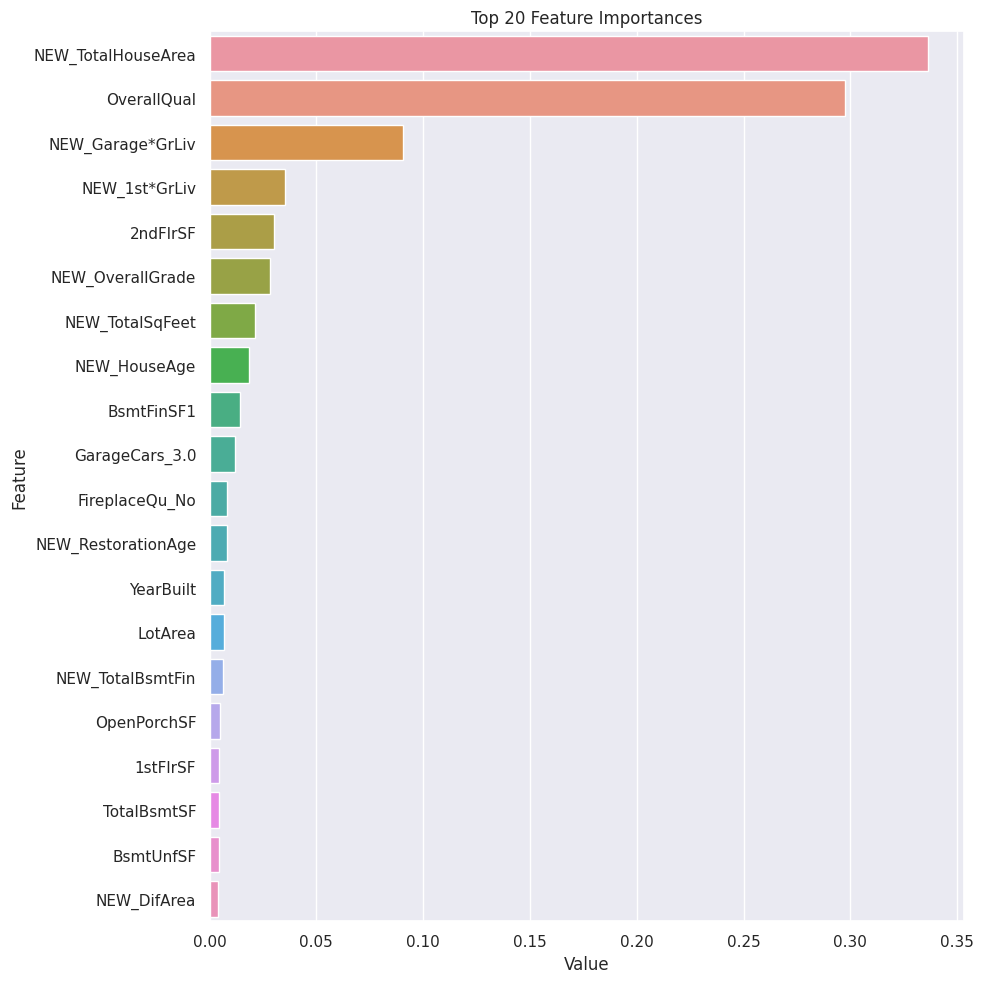

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

def plot_importance(model, features, num=20, save=False, figsize=(10, 10)):
    """
    Plots the feature importances of a fitted Gradient Boosting Regressor model with a specified number of top features and graph size.
    
    Args:
        model: A fitted GradientBoostingRegressor object that has the `feature_importances_` attribute.
        features (pd.DataFrame): DataFrame of features used in the model.
        num (int, optional): Number of top features to plot. Defaults to 20.
        save (bool, optional): If True, saves the plot to a file named 'importances.png'.
        figsize (tuple, optional): Figure size in inches (width, height).
        
    Returns:
        None: Shows and optionally saves a plot of the feature importances.
    """
    # Extract feature importances and match them with feature names
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    
    # Create a bar plot of feature importances for the top 'num' features
    plt.figure(figsize=figsize)
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:num])
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Save the plot to a file if save is True
    if save:
        plt.savefig("importances.png")

# Initialize and fit a GradientBoostingRegressor to the dataset
gbm_model = GradientBoostingRegressor(random_state=46)
gbm_model.fit(X, y)

# Plot the top 20 feature importances of the model
plot_importance(gbm_model, X, num=20, figsize=(10, 10))

In [31]:
# Bonus: Predict the empty salePrice variables in the test data and create a dataframe suitable for submitting to the Kaggle page 
# and upload your results.

# Initialize and fit the GradientBoostingRegressor model
gbm_model = GradientBoostingRegressor(random_state=46)  # Adding a random_state for reproducibility
gbm_model.fit(X, y)

# Predict 'SalePrice' for the test set
# Ensure to drop 'Id' and 'SalePrice' columns from the test set as they are not features
predictions = gbm_model.predict(test_df.drop(["Id", "SalePrice"], axis=1))

# Create a submission DataFrame
# Use 'Id' from the test set and pair it with the predictions

# Note: If 'Id' is not the index, replace 'test_df.index' with 'test_df['Id']'
submission_df = pd.DataFrame({"Id": test_df['Id'], "SalePrice": predictions})

# Convert 'Id' column to integer
submission_df['Id'] = submission_df['Id'].astype(int)

# Save the submission DataFrame to a CSV file, without the index
submission_df.to_csv("submission.csv", index=False)

# Print a message confirming the file has been saved
print("Submission file 'submission.csv' has been saved.")


Submission file 'submission.csv' has been saved.
